# Preserving a multi-variable pointwise quantity of interest (QoI) with safeguards

In this example, we compute the wind kinetic energy per unit mass from a dataset of wind components `u` and `v`. We compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the derived pointwise kinetic energy when compressing the `u` and `v` variables (stacked into one variable). Finally, we apply safeguards to guarantee an error bound on the derived kinetic energy.

Stacking `u` and `v` into one variable that is then compressed is possible because `u` and `v` have very similar data distributions.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
def compute_kinetic_energy(ERA5: xr.Dataset) -> xr.DataArray:
    ERA5_KE = 0.5 * (np.square(ERA5["u"]) + np.square(ERA5["v"]))
    ERA5_KE.attrs.update(
        long_name="wind kinetic energy per unit mass", units="m**2 s**-2"
    )

    return ERA5_KE

In [5]:
ERA5_KE = compute_kinetic_energy(ERA5)

In [6]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [7]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [8]:
def plot_kinetic_energy(
    my_ERA5: xr.Dataset,
    cr,
    chart,
    title,
    span,
    error=False,
):
    import copy

    my_ERA5_KE = compute_kinetic_energy(my_ERA5)

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_KE - ERA5_KE).compute()

        err_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
        err_V = np.amax(np.abs(my_ERA5["v"] - ERA5["v"]))
        err_KE = np.amax(np.abs(my_ERA5_KE - ERA5_KE))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        # plot the square root of kinetic energy to better capture scale
        da = np.sqrt(my_ERA5_KE)
        da.attrs.update(long_name=f"sqrt({da.long_name})", units="m**1 s**-1")

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    if error:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 22)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "coolwarm"
    else:
        style._levels = earthkit.plots.styles.levels.Levels(np.linspace(0, span, 22))
        style._legend_kwargs["ticks"] = np.linspace(0, span, 5)
        style._colors = "viridis"

    extend_left = np.nanmin(da) < (-span if error else 0)
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_U:.02}  $L_{{{{\infty}}}}(\hat{{{{v}}}})$={err_V:.02}  $L_{{{{\infty}}}}(\hat{{{{KE}}}})$={err_KE:.03}"
        )
    else:
        chart.title(f"{title}\n")

    if error:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(
        da.values.flatten(), range=(-span if error else 0, span), bins=21
    )
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    cax = cb.ax.inset_axes([0.0, 1.25, 1.0, 1.0])
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(-span if error else 0, span)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [9]:
# Since numcodecs-safeguards only supports single-variable safeguarding, we
# stack the u and v variables into a combined variable.
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5.u.dims, ERA5_UV.shape

(('latitude', 'longitude'), (721, 1440, 2))

## Compressing u and v with lossy compressors

We configure each compressor with an absolute error bound of 0.125 m/s over the u-v array, which seems to provide similar errors on the derived kinetic energy.

In [10]:
eb_abs = 0.125

In [11]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

ERA5_UV_zfp_enc = zfp.encode(ERA5_UV)
ERA5_UV_zfp = zfp.decode(ERA5_UV_zfp_enc)

ERA5_zfp = ERA5.copy(data=dict(u=ERA5_UV_zfp[..., 0], v=ERA5_UV_zfp[..., 1]))
ERA5_zfp_cr = ERA5_UV.nbytes / ERA5_UV_zfp_enc.nbytes

In [12]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ERA5_UV_sz3_enc = sz3.encode(ERA5_UV)
ERA5_UV_sz3 = sz3.decode(ERA5_UV_sz3_enc)

ERA5_sz3 = ERA5.copy(data=dict(u=ERA5_UV_sz3[..., 0], v=ERA5_UV_sz3[..., 1]))
ERA5_sz3_cr = ERA5_UV.nbytes / ERA5_UV_sz3_enc.nbytes

In [13]:
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

ERA5_UV_sperr_enc = sperr.encode(ERA5_UV)
ERA5_UV_sperr = sperr.decode(ERA5_UV_sperr_enc)

ERA5_sperr = ERA5.copy(data=dict(u=ERA5_UV_sperr[..., 0], v=ERA5_UV_sperr[..., 1]))
ERA5_sperr_cr = ERA5_UV.nbytes / ERA5_UV_sperr_enc.nbytes

## Compressing u and v using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived kinetic energy, choosing an error bound that is comparible to the errors produced by the lossy compression methods above.

The kinetic energy computation is translated into a quantity of interest. Even though kinetic energy is a pointwise quantity, stacking `u` and `v` into a single variable means that we now compute the kinetic energy over a two-element `(u, v)` local neighbourhood.

In [14]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

ERA5_sg = dict()
ERA5_sg_cr = dict()

for codec in [
    ZeroCodec(),
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="0.5 * (square(X[0]) + square(X[1]))",
                type="abs",
                eb=1,
                neighbourhood=[
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
    )

    ERA5_UV_sg_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg = sg.decode(ERA5_UV_sg_enc)

    ERA5_sg[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg[..., 0], v=ERA5_UV_sg[..., 1])
    )
    ERA5_sg_cr[codec.codec_id] = ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_enc).nbytes

100%|██████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.90it/s]


## Visual comparison of the error distributions for the derived kinetic energy

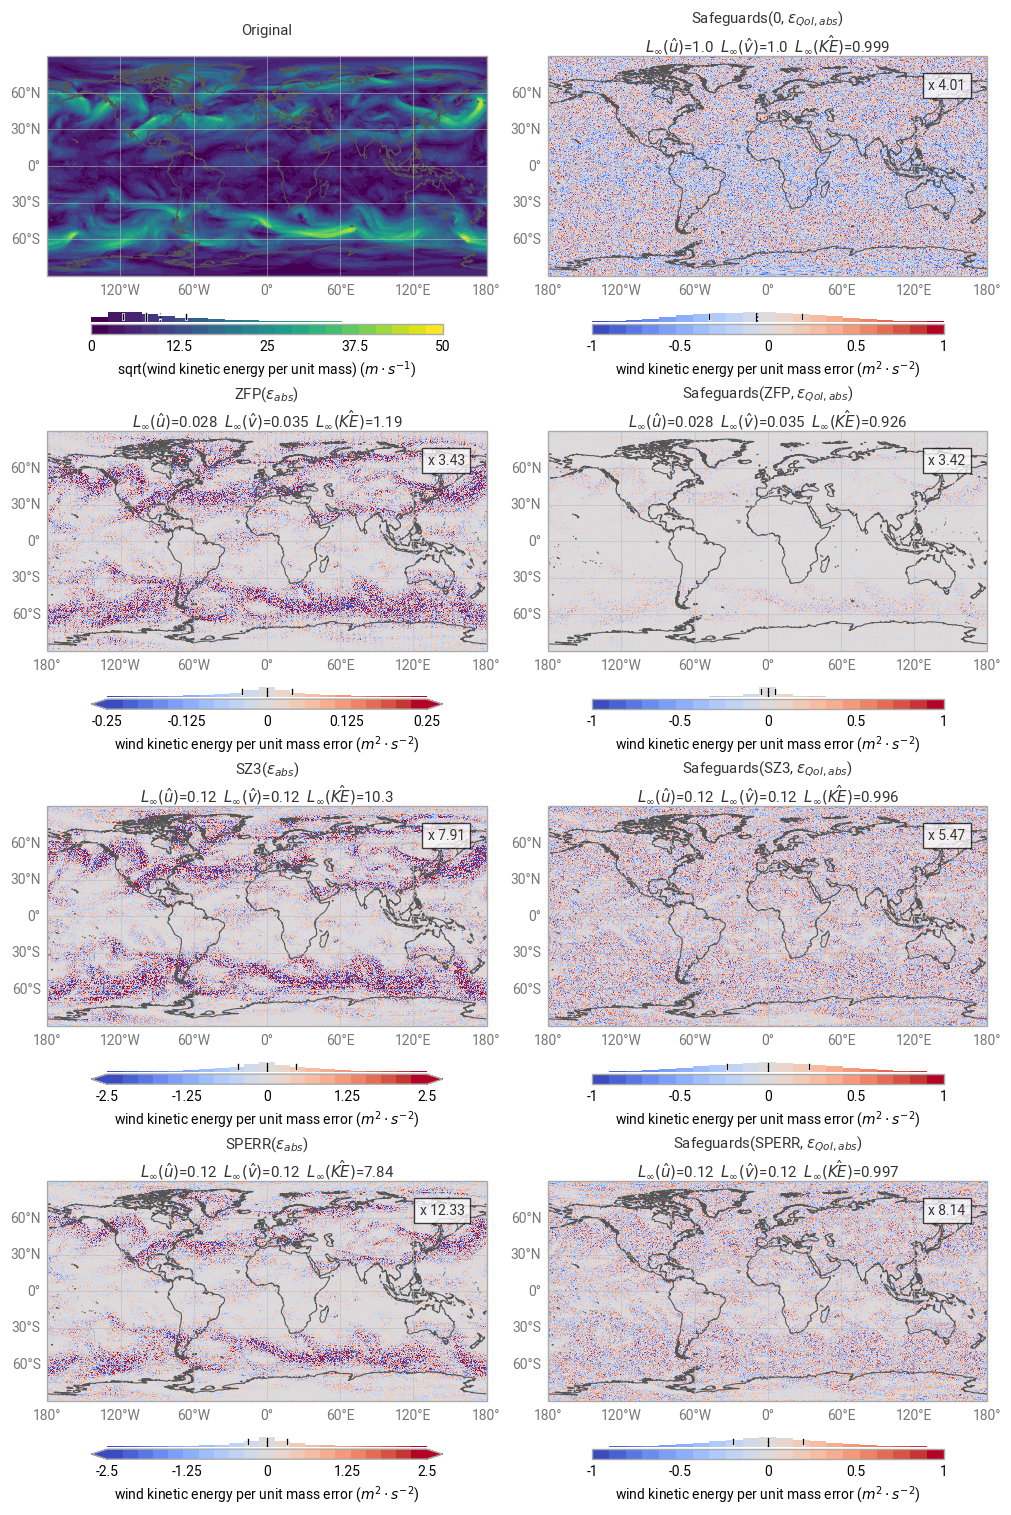

In [15]:
fig = earthkit.plots.Figure(
    size=(10, 15),
    rows=4,
    columns=2,
)

plot_kinetic_energy(ERA5, 1.0, fig.add_map(0, 0), "Original", span=50)
plot_kinetic_energy(
    ERA5_zfp,
    ERA5_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    span=0.25,
    error=True,
)
plot_kinetic_energy(
    ERA5_sz3,
    ERA5_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    span=2.5,
    error=True,
)
plot_kinetic_energy(
    ERA5_sperr,
    ERA5_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    span=2.5,
    error=True,
)

plot_kinetic_energy(
    ERA5_sg["zero"],
    ERA5_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
    span=1.0,
    error=True,
)
plot_kinetic_energy(
    ERA5_sg["zfp.rs"],
    ERA5_sg_cr["zfp.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
    span=1.0,
    error=True,
)
plot_kinetic_energy(
    ERA5_sg["sz3.rs"],
    ERA5_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
    span=1.0,
    error=True,
)
plot_kinetic_energy(
    ERA5_sg["sperr.rs"],
    ERA5_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
    span=1.0,
    error=True,
)

fig.save("kinetic-energy.pdf")